# Rookie 5 Year Predictions

#### Seraj, Isaac, and Chris

![](images/bball_bg.jpg)

## Overview

We will be using various classification models to best predict a binary target using a NBA Player Statistics dataset, specifically to predict whether or not their career duration was over 5 years.

### Business Problem

Classify which NBA players to keep based on their stats of their first season (5-years)

Our goal is to help NBA front offices make better informed personnel decisions on their rookie players based on the historical data of NBA rookies from 1980 to 2012. These personnel decisions include but are not limited to, contract extensions, trading players, and/or releasing players from their contracts
	Context → average NBA career is 4.5 to 4.8 years, NBA rookie contracts are 4 years in total so many draftees in the first round are expected to be able to contributors (exceptions for very young players and foreign players)

Further explanation: 
(based on a rookie’s stats, which specific stats are most predictive of having an NBA career longer than 5 years?)



### Stakeholders

NBA front offices

Specifically, NBA general managers can find this useful because these are the people in charge of team operations and personnel. They hold the ability to trade, release, and sign players in free agency or to contract extensions. A player’s length of career is not solely decided by the stats of his rookie season, but this insight can help GMs get a better picture of which players have a better chance of “sticking” in the league than others.


## Data

We have used two datasets to make our predictive models, 'nba-players.csv' from Kaggle and 'NBA Rookies by Year.xlsx' from DataWorld. We concatted both dataset together to get the full array of statistics we were interested in exploring and saved it as nba.csv. Features are completely performance based and does not include some features that may lead to bias, such as Race. All features are an average per game statistic except for name(Player Name), gp(Games Played), target_5yrs(Career Duration > 5 Years), and Year Drafted. The dataframe column and descriptions are listed below:

| Columns | Descriptions |
| --- | --- |
| name | Player Name |
| gp | Games played |
| min | Minutes Played |
| pts | Points per Game |
| fgm | Field Goals made |
| fga | Field Goal Attempts |
| fg | Field Goal Percentage |
| 3p_made | 3 Points made |
| 3pa | 3 Point Attempts |
| 3p | 3 Point Percentage |
| ftm | Free Throw made |
| fta | Free Throw Attempts |
| ft | Free Throw Percentage |
| oreb | Offensive Rebounds |
| dreb | Defensive Rebounds |
| reb | Rebounds |
| ast | Assists |
| stl |Steals |
| blk | Blocks |
| tov | Turnovers |
| target_5yrs | Career Duration > 5 years|
| Year Drafted | Year Drafted |

## Data Preparation

### Imports

In [123]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [124]:
df = pd.read_csv('Dataset/nba.csv', index_col=0)

### Helper Functions

### Dropping Unnecessary Features

In [125]:
df = df[df['Year Drafted'] < 2013]

In [126]:
# setting the variables to check
X = df.drop(['name', 'target_5yrs'], axis=1)

In [110]:
df.corr()['target_5yrs'].sort_values()

Year Drafted    0.046684
3p              0.053980
3pa             0.105656
3p_made         0.111697
ft              0.128796
ast             0.182543
fg              0.197417
blk             0.225302
stl             0.249202
tov             0.261089
oreb            0.271184
fta             0.275466
ftm             0.279845
fga             0.297733
fgm             0.315642
reb             0.315770
pts             0.316787
dreb            0.324244
min             0.342878
gp              0.359454
target_5yrs     1.000000
Name: target_5yrs, dtype: float64

In [111]:
df['target_5yrs'].value_counts(normalize=True)

1    0.666667
0    0.333333
Name: target_5yrs, dtype: float64

Many of the features available to us are very similar and highly correlated with each other. For this reason, we will drop the others but keep one. For example, there are stats for Offensive Rebounds, Defensive Rebounds, and Rebounds (total). In this case, we will keep the Rebounds (total).
Similarly --> FieldGoalsMade (FGM), FieldGoalAttempts(FGA), FieldGoalPercentage(FG%) --> keeping FG% even though FGM is more highly correlated with target_5yrs. We chose FG% because it is a measure of scoring efficiency while FGM is highly correlated with FGA. FGA can be explained by the role the rookie has on their team and we know that each rookie's role is different depending on the talent of the roster they are on.
3P_made, 3PA, 3P%, --> we will keep 3P% to stay consistent in our measures of a players' scoring efficiency.
Finally... FreeThrowsMade (FTM), FreeThrowsAttempted (FTA), FreeThrowPercentage(FT) --> keep FT to maintain consistency for player's scoring efficiency.

In [112]:
df = df.drop(['name','fgm','fga','3p_made','3pa','ftm','fta','oreb','dreb'], axis=1)

## Modeling

### Helper Functions

### Baseline Model

#### Using the 5 highest correlated features with our target - games_played, minutes(per game), points(per game), rebounds, and turnovers

In [113]:
X = df[['fg']]
y = df['target_5yrs']

#### Splitting into training, validation, and test set; Test set will be used at the very end of our modeling process and fit to our best performing model

In [114]:


# first, split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# splitting the training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [115]:
# scaling the data
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

#### Logistic Regression Model

In [116]:
# base model --> default parameters
log_model = LogisticRegression(random_state=42)

# fit training data
log_model.fit(scaled_X_train, y_train)

LogisticRegression(random_state=42)

In [117]:
log_model.coef_

array([[0.52073291]])

This means:
* We can expect the **odds** of the rookie's career being over 5 years to **increase** (the original coeff was negative) per unit increase of games played.
* We can expect the **odds** of the rookie's career being over 5 years to **decrease** (the original coeff was negative) per unit increase of games played

In [118]:
y_pred = log_model.predict(scaled_X_val)

In [119]:
accuracy_score(y_val,y_pred)

0.6585365853658537

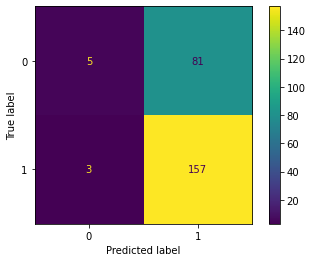

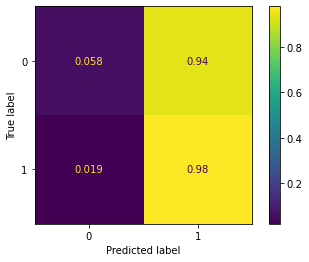

In [120]:
plot_confusion_matrix(log_model, scaled_X_val, y_val)
plot_confusion_matrix(log_model, scaled_X_val, y_val,normalize='true')

#### Interpreting the Baseline Model

Our simple model (baseline model) is a logistic regression model because out of the other models we tried such as KNN and SVM, logistic regression had the highest accuracy score and f1_score. The reason we went with a better performing baseline model is to make sure we make a high performing final model.


We included only the five features that were most highly correlated with our target variable into our baseline model. The features included in our baseline model are number of games played, minutes played per game, points per game, rebounds per game, and turnovers per game. 

### Model Iteration 1

### Model Iteration 2

### Model Iteration 3

### Model Iteration 4

### Final Model

## Conclusion